In [1]:
import torch
import numpy as np
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
from utils.readData import read_dataset
from utils.ResNet import ResNet18
import torchvision


/home/mxx/anaconda3/envs/myenv2/lib/python3.9/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")
/home/mxx/anaconda3/envs/myenv2/lib/python3.9/site-packages/torch/cuda/__init__.py:141: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
# set device
device = 'cuda:1' if torch.cuda.is_available() else 'cpu'

We down the CIFAR-10 dataset by torchvision.datasets.CIFAR10().

In [3]:
# down CIFAR10 dataset
# torchvision.datasets.CIFAR10(root='dataset',download=True) 

Data augmentation

In [4]:
# read data and arguement
batch_size = 16 #128
#
cifar10_dir = '/home/mxx/ZZY/deep-learning-mini-project-spring-24-nyu/cifar-10-python/cifar-10-batches-py'
#
train_loader,valid_loader,test_loader = read_dataset(batch_size=batch_size,pic_path=cifar10_dir)

Loading and modifying the model. The 7x7 downsampling convolution and maxpooling operation of ResNet18 network is easy to lose information. Here we use a 3x3 downsampling convolution and delete maxpooling operation. This makes the receptive field larger and learns more information.


In [5]:
n_class = 10
model = ResNet18()
model.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1, bias=False)
model.fc = torch.nn.Linear(512, n_class) 
model = model.to(device)

In [6]:
#Cross-entropy loss function
criterion = nn.CrossEntropyLoss().to(device)

Training the model. We use the SGD optimizer and a dynamic lr. If the loss of the validation set trained after 10 epochs does not decrease, the lr will be halved. The model is trained for 100 epochs.

In [7]:
n_epochs = 100
valid_loss_min = np.Inf # track change in validation loss
accuracy = []
lr = 0.1
counter = 0

trainloss_list = []
validloss_list = []


In [8]:
for epoch in tqdm(range(1, n_epochs+1)):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    total_sample = 0
    right_sample = 0
    
    #dynamic lr
    if counter/10 ==1:
        counter = 0
        lr = lr*0.5
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
    ###################
    # model from train set#
    ###################
    model.train() 
    for data, target in train_loader:
        data = data.to(device)
        target = target.to(device)
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data).to(device) 
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # Validating models#
    ######################

    model.eval()  
    for data, target in valid_loader:
        data = data.to(device)
        target = target.to(device)
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data).to(device)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
        # convert output probabilities to predicted class
        _, pred = torch.max(output, 1)    
        # compare predictions to true label
        correct_tensor = pred.eq(target.data.view_as(pred))
        # correct = np.squeeze(correct_tensor.to(device).numpy())
        total_sample += batch_size
        for i in correct_tensor:
            if i:
                right_sample += 1
    print("Accuracy:",100*right_sample/total_sample,"%")
    accuracy.append(right_sample/total_sample)
  
    # Calculate the average loss
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
    trainloss_list.append(train_loss)
    validloss_list.append(valid_loss)
        
    # Print loss
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # Save model when the validation loss decrease
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,valid_loss))
        torch.save(model.state_dict(), 'checkpoint/resnet18_cifar10_410.pt')
        valid_loss_min = valid_loss
        counter = 0
    else:
        counter += 1

  0%|          | 0/100 [00:00<?, ?it/s]

Accuracy: 35.08 %
Epoch: 1 	Training Loss: 2.040648 	Validation Loss: 1.801633
Validation loss decreased (inf --> 1.801633).  Saving model ...


  1%|          | 1/100 [05:35<9:14:23, 335.99s/it]

Accuracy: 45.23 %
Epoch: 2 	Training Loss: 1.735835 	Validation Loss: 1.538904
Validation loss decreased (1.801633 --> 1.538904).  Saving model ...


  2%|▏         | 2/100 [11:19<9:16:04, 340.45s/it]

Accuracy: 53.74 %
Epoch: 3 	Training Loss: 1.542985 	Validation Loss: 1.330810
Validation loss decreased (1.538904 --> 1.330810).  Saving model ...


  4%|▍         | 4/100 [22:10<8:46:24, 329.00s/it]

Accuracy: 35.69 %
Epoch: 4 	Training Loss: 1.408853 	Validation Loss: 2.330612
Accuracy: 58.4 %
Epoch: 5 	Training Loss: 1.316968 	Validation Loss: 1.226293
Validation loss decreased (1.330810 --> 1.226293).  Saving model ...


  6%|▌         | 6/100 [33:01<8:32:04, 326.86s/it]

Accuracy: 51.25 %
Epoch: 6 	Training Loss: 1.267674 	Validation Loss: 1.657372


  7%|▋         | 7/100 [38:17<8:21:01, 323.24s/it]

Accuracy: 53.77 %
Epoch: 7 	Training Loss: 1.224793 	Validation Loss: 1.549655


  8%|▊         | 8/100 [43:40<8:15:55, 323.43s/it]

Accuracy: 58.17 %
Epoch: 8 	Training Loss: 1.200461 	Validation Loss: 1.524624
Accuracy: 63.49 %
Epoch: 9 	Training Loss: 1.179862 	Validation Loss: 1.155754
Validation loss decreased (1.226293 --> 1.155754).  Saving model ...


 10%|█         | 10/100 [54:19<8:01:57, 321.31s/it]

Accuracy: 62.08 %
Epoch: 10 	Training Loss: 1.169975 	Validation Loss: 1.158957
Accuracy: 66.64 %
Epoch: 11 	Training Loss: 1.156838 	Validation Loss: 0.976471
Validation loss decreased (1.155754 --> 0.976471).  Saving model ...


 12%|█▏        | 12/100 [1:04:43<7:42:09, 315.11s/it]

Accuracy: 66.59 %
Epoch: 12 	Training Loss: 1.151452 	Validation Loss: 0.976572


 13%|█▎        | 13/100 [1:10:02<7:38:40, 316.33s/it]

Accuracy: 55.97 %
Epoch: 13 	Training Loss: 1.140724 	Validation Loss: 1.527449


 14%|█▍        | 14/100 [1:15:18<7:33:20, 316.29s/it]

Accuracy: 61.31 %
Epoch: 14 	Training Loss: 1.140879 	Validation Loss: 1.133322


 15%|█▌        | 15/100 [1:20:38<7:29:37, 317.38s/it]

Accuracy: 61.02 %
Epoch: 15 	Training Loss: 1.135291 	Validation Loss: 1.303886


 16%|█▌        | 16/100 [1:25:59<7:25:51, 318.47s/it]

Accuracy: 63.8 %
Epoch: 16 	Training Loss: 1.134412 	Validation Loss: 1.103605


 17%|█▋        | 17/100 [1:31:23<7:22:43, 320.05s/it]

Accuracy: 63.14 %
Epoch: 17 	Training Loss: 1.133643 	Validation Loss: 1.122659


 18%|█▊        | 18/100 [1:36:51<7:21:00, 322.69s/it]

Accuracy: 56.67 %
Epoch: 18 	Training Loss: 1.130923 	Validation Loss: 1.435939


 19%|█▉        | 19/100 [1:42:03<7:11:03, 319.30s/it]

Accuracy: 52.03 %
Epoch: 19 	Training Loss: 1.125899 	Validation Loss: 1.564151


 20%|██        | 20/100 [1:47:27<7:07:36, 320.71s/it]

Accuracy: 66.9 %
Epoch: 20 	Training Loss: 1.126911 	Validation Loss: 1.016089


 21%|██        | 21/100 [1:52:46<7:01:45, 320.32s/it]

Accuracy: 57.9 %
Epoch: 21 	Training Loss: 1.132009 	Validation Loss: 1.328715
Accuracy: 72.99 %
Epoch: 22 	Training Loss: 0.910779 	Validation Loss: 0.812726
Validation loss decreased (0.976471 --> 0.812726).  Saving model ...


 23%|██▎       | 23/100 [2:03:39<6:55:13, 323.55s/it]

Accuracy: 72.23 %
Epoch: 23 	Training Loss: 0.906402 	Validation Loss: 0.826875


 24%|██▍       | 24/100 [2:08:58<6:48:09, 322.23s/it]

Accuracy: 71.19 %
Epoch: 24 	Training Loss: 0.892967 	Validation Loss: 0.831543


 25%|██▌       | 25/100 [2:14:02<6:35:35, 316.47s/it]

Accuracy: 65.87 %
Epoch: 25 	Training Loss: 0.883539 	Validation Loss: 1.142352


 26%|██▌       | 26/100 [2:19:22<6:31:47, 317.66s/it]

Accuracy: 68.26 %
Epoch: 26 	Training Loss: 0.866418 	Validation Loss: 0.996830


 27%|██▋       | 27/100 [2:24:38<6:25:46, 317.08s/it]

Accuracy: 72.29 %
Epoch: 27 	Training Loss: 0.858682 	Validation Loss: 0.815573


 28%|██▊       | 28/100 [2:29:50<6:18:53, 315.75s/it]

Accuracy: 70.89 %
Epoch: 28 	Training Loss: 0.854057 	Validation Loss: 0.864236


 29%|██▉       | 29/100 [2:35:13<6:15:57, 317.71s/it]

Accuracy: 71.4 %
Epoch: 29 	Training Loss: 0.848782 	Validation Loss: 0.857606
Accuracy: 75.88 %
Epoch: 30 	Training Loss: 0.843790 	Validation Loss: 0.744905
Validation loss decreased (0.812726 --> 0.744905).  Saving model ...


 31%|███       | 31/100 [2:45:51<6:07:03, 319.19s/it]

Accuracy: 65.96 %
Epoch: 31 	Training Loss: 0.837510 	Validation Loss: 1.078906
Accuracy: 75.75 %
Epoch: 32 	Training Loss: 0.835847 	Validation Loss: 0.737183
Validation loss decreased (0.744905 --> 0.737183).  Saving model ...


 33%|███▎      | 33/100 [2:56:24<5:55:01, 317.93s/it]

Accuracy: 75.35 %
Epoch: 33 	Training Loss: 0.835809 	Validation Loss: 0.741917


 34%|███▍      | 34/100 [3:01:49<5:52:03, 320.06s/it]

Accuracy: 75.2 %
Epoch: 34 	Training Loss: 0.829221 	Validation Loss: 0.751062


 35%|███▌      | 35/100 [3:07:14<5:48:18, 321.51s/it]

Accuracy: 69.45 %
Epoch: 35 	Training Loss: 0.831824 	Validation Loss: 0.942505


 36%|███▌      | 36/100 [3:12:37<5:43:29, 322.02s/it]

Accuracy: 71.52 %
Epoch: 36 	Training Loss: 0.826633 	Validation Loss: 0.853734


 37%|███▋      | 37/100 [3:17:59<5:38:11, 322.08s/it]

Accuracy: 70.35 %
Epoch: 37 	Training Loss: 0.823929 	Validation Loss: 0.958788


 38%|███▊      | 38/100 [3:23:13<5:30:22, 319.72s/it]

Accuracy: 65.56 %
Epoch: 38 	Training Loss: 0.822263 	Validation Loss: 1.143111


 39%|███▉      | 39/100 [3:28:35<5:25:43, 320.39s/it]

Accuracy: 72.02 %
Epoch: 39 	Training Loss: 0.816618 	Validation Loss: 0.839742


 40%|████      | 40/100 [3:33:54<5:19:45, 319.77s/it]

Accuracy: 72.56 %
Epoch: 40 	Training Loss: 0.815933 	Validation Loss: 0.836409


 41%|████      | 41/100 [3:39:16<5:15:19, 320.68s/it]

Accuracy: 71.61 %
Epoch: 41 	Training Loss: 0.824600 	Validation Loss: 0.862233
Accuracy: 77.3 %
Epoch: 42 	Training Loss: 0.816633 	Validation Loss: 0.685404
Validation loss decreased (0.737183 --> 0.685404).  Saving model ...


 43%|████▎     | 43/100 [3:50:13<5:08:34, 324.82s/it]

Accuracy: 72.66 %
Epoch: 43 	Training Loss: 0.809309 	Validation Loss: 0.833534


 44%|████▍     | 44/100 [3:55:33<5:01:42, 323.26s/it]

Accuracy: 74.08 %
Epoch: 44 	Training Loss: 0.812006 	Validation Loss: 0.810321


 45%|████▌     | 45/100 [4:00:59<4:57:07, 324.14s/it]

Accuracy: 77.18 %
Epoch: 45 	Training Loss: 0.815646 	Validation Loss: 0.694515


 46%|████▌     | 46/100 [4:06:29<4:53:25, 326.04s/it]

Accuracy: 66.38 %
Epoch: 46 	Training Loss: 0.810611 	Validation Loss: 1.043822


 47%|████▋     | 47/100 [4:12:01<4:49:31, 327.76s/it]

Accuracy: 74.88 %
Epoch: 47 	Training Loss: 0.804952 	Validation Loss: 0.770841


 48%|████▊     | 48/100 [4:17:29<4:44:03, 327.76s/it]

Accuracy: 73.4 %
Epoch: 48 	Training Loss: 0.807716 	Validation Loss: 0.803725


 49%|████▉     | 49/100 [4:23:03<4:40:08, 329.58s/it]

Accuracy: 70.28 %
Epoch: 49 	Training Loss: 0.805148 	Validation Loss: 0.918679


 50%|█████     | 50/100 [4:28:37<4:35:57, 331.14s/it]

Accuracy: 69.43 %
Epoch: 50 	Training Loss: 0.802367 	Validation Loss: 1.034565


 51%|█████     | 51/100 [4:34:17<4:32:30, 333.69s/it]

Accuracy: 68.98 %
Epoch: 51 	Training Loss: 0.804272 	Validation Loss: 1.029894


 52%|█████▏    | 52/100 [4:40:06<4:30:29, 338.11s/it]

Accuracy: 69.15 %
Epoch: 52 	Training Loss: 0.802126 	Validation Loss: 0.986333
Accuracy: 78.68 %
Epoch: 53 	Training Loss: 0.581010 	Validation Loss: 0.654493
Validation loss decreased (0.685404 --> 0.654493).  Saving model ...


 53%|█████▎    | 53/100 [4:45:58<4:28:18, 342.51s/it]

Accuracy: 78.88 %
Epoch: 54 	Training Loss: 0.570427 	Validation Loss: 0.647928
Validation loss decreased (0.654493 --> 0.647928).  Saving model ...


 55%|█████▌    | 55/100 [4:57:38<4:19:44, 346.32s/it]

Accuracy: 79.45 %
Epoch: 55 	Training Loss: 0.554199 	Validation Loss: 0.658563
Accuracy: 80.1 %
Epoch: 56 	Training Loss: 0.549208 	Validation Loss: 0.599311
Validation loss decreased (0.647928 --> 0.599311).  Saving model ...


 57%|█████▋    | 57/100 [5:09:49<4:14:52, 355.64s/it]

Accuracy: 77.19 %
Epoch: 57 	Training Loss: 0.531326 	Validation Loss: 0.748217


 58%|█████▊    | 58/100 [5:15:49<4:09:51, 356.94s/it]

Accuracy: 78.08 %
Epoch: 58 	Training Loss: 0.528499 	Validation Loss: 0.694627


 59%|█████▉    | 59/100 [5:21:53<4:05:31, 359.31s/it]

Accuracy: 79.93 %
Epoch: 59 	Training Loss: 0.516862 	Validation Loss: 0.631456


 60%|██████    | 60/100 [5:28:09<4:02:50, 364.26s/it]

Accuracy: 77.62 %
Epoch: 60 	Training Loss: 0.508137 	Validation Loss: 0.732583


 61%|██████    | 61/100 [5:34:19<3:57:55, 366.04s/it]

Accuracy: 78.71 %
Epoch: 61 	Training Loss: 0.500563 	Validation Loss: 0.708297


 62%|██████▏   | 62/100 [5:40:32<3:53:02, 367.97s/it]

Accuracy: 76.86 %
Epoch: 62 	Training Loss: 0.506427 	Validation Loss: 0.768922


 63%|██████▎   | 63/100 [5:46:42<3:47:13, 368.47s/it]

Accuracy: 77.48 %
Epoch: 63 	Training Loss: 0.499911 	Validation Loss: 0.730196


 64%|██████▍   | 64/100 [5:52:53<3:41:39, 369.44s/it]

Accuracy: 79.93 %
Epoch: 64 	Training Loss: 0.501140 	Validation Loss: 0.618494


 65%|██████▌   | 65/100 [5:59:07<3:36:17, 370.79s/it]

Accuracy: 78.06 %
Epoch: 65 	Training Loss: 0.485278 	Validation Loss: 0.777226


 66%|██████▌   | 66/100 [6:05:18<3:30:09, 370.88s/it]

Accuracy: 75.87 %
Epoch: 66 	Training Loss: 0.490373 	Validation Loss: 0.785326


 67%|██████▋   | 67/100 [6:11:31<3:24:14, 371.34s/it]

Accuracy: 82.03 %
Epoch: 67 	Training Loss: 0.234212 	Validation Loss: 0.624390


 68%|██████▊   | 68/100 [6:17:39<3:17:38, 370.58s/it]

Accuracy: 79.71 %
Epoch: 68 	Training Loss: 0.213562 	Validation Loss: 0.771645


 69%|██████▉   | 69/100 [6:23:46<3:10:46, 369.24s/it]

Accuracy: 78.06 %
Epoch: 69 	Training Loss: 0.240943 	Validation Loss: 0.848156


 70%|███████   | 70/100 [6:29:54<3:04:27, 368.90s/it]

Accuracy: 79.96 %
Epoch: 70 	Training Loss: 0.249796 	Validation Loss: 0.733436


 71%|███████   | 71/100 [6:36:09<2:59:11, 370.75s/it]

Accuracy: 80.32 %
Epoch: 71 	Training Loss: 0.250853 	Validation Loss: 0.693631


 72%|███████▏  | 72/100 [6:42:20<2:53:05, 370.92s/it]

Accuracy: 80.17 %
Epoch: 72 	Training Loss: 0.250454 	Validation Loss: 0.709050


 73%|███████▎  | 73/100 [6:48:28<2:46:30, 370.03s/it]

Accuracy: 80.55 %
Epoch: 73 	Training Loss: 0.247006 	Validation Loss: 0.675545


 74%|███████▍  | 74/100 [6:54:33<2:39:41, 368.51s/it]

Accuracy: 80.35 %
Epoch: 74 	Training Loss: 0.249796 	Validation Loss: 0.690043


 75%|███████▌  | 75/100 [7:00:35<2:32:45, 366.61s/it]

Accuracy: 80.94 %
Epoch: 75 	Training Loss: 0.246309 	Validation Loss: 0.688570


 76%|███████▌  | 76/100 [7:06:44<2:26:51, 367.16s/it]

Accuracy: 80.4 %
Epoch: 76 	Training Loss: 0.243297 	Validation Loss: 0.722370


 77%|███████▋  | 77/100 [7:12:48<2:20:26, 366.38s/it]

Accuracy: 83.44 %
Epoch: 77 	Training Loss: 0.075428 	Validation Loss: 0.627956


 78%|███████▊  | 78/100 [7:18:51<2:13:57, 365.36s/it]

Accuracy: 83.97 %
Epoch: 78 	Training Loss: 0.029198 	Validation Loss: 0.645210


 79%|███████▉  | 79/100 [7:25:02<2:08:29, 367.12s/it]

Accuracy: 84.62 %
Epoch: 79 	Training Loss: 0.019916 	Validation Loss: 0.641798


 80%|████████  | 80/100 [7:31:11<2:02:29, 367.48s/it]

Accuracy: 81.82 %
Epoch: 80 	Training Loss: 0.048684 	Validation Loss: 0.742668


 81%|████████  | 81/100 [7:37:23<1:56:47, 368.83s/it]

Accuracy: 81.01 %
Epoch: 81 	Training Loss: 0.108689 	Validation Loss: 0.723101


 82%|████████▏ | 82/100 [7:43:28<1:50:20, 367.79s/it]

Accuracy: 78.84 %
Epoch: 82 	Training Loss: 0.128796 	Validation Loss: 0.803620


 83%|████████▎ | 83/100 [7:49:39<1:44:28, 368.74s/it]

Accuracy: 81.09 %
Epoch: 83 	Training Loss: 0.129613 	Validation Loss: 0.721814


 84%|████████▍ | 84/100 [7:55:51<1:38:34, 369.63s/it]

Accuracy: 81.23 %
Epoch: 84 	Training Loss: 0.121101 	Validation Loss: 0.714851


 85%|████████▌ | 85/100 [8:02:02<1:32:30, 370.06s/it]

Accuracy: 80.43 %
Epoch: 85 	Training Loss: 0.120538 	Validation Loss: 0.767812


 86%|████████▌ | 86/100 [8:08:11<1:26:16, 369.73s/it]

Accuracy: 81.45 %
Epoch: 86 	Training Loss: 0.120828 	Validation Loss: 0.753535


 87%|████████▋ | 87/100 [8:14:13<1:19:35, 367.36s/it]

Accuracy: 84.62 %
Epoch: 87 	Training Loss: 0.036717 	Validation Loss: 0.603594
Accuracy: 85.23 %
Epoch: 88 	Training Loss: 0.011090 	Validation Loss: 0.598055
Validation loss decreased (0.599311 --> 0.598055).  Saving model ...


 89%|████████▉ | 89/100 [8:26:21<1:06:54, 364.97s/it]

Accuracy: 84.78 %
Epoch: 89 	Training Loss: 0.006303 	Validation Loss: 0.599981


 90%|█████████ | 90/100 [8:32:37<1:01:25, 368.57s/it]

Accuracy: 85.07 %
Epoch: 90 	Training Loss: 0.005278 	Validation Loss: 0.600800
Accuracy: 85.5 %
Epoch: 91 	Training Loss: 0.003781 	Validation Loss: 0.558666
Validation loss decreased (0.598055 --> 0.558666).  Saving model ...


 92%|█████████▏| 92/100 [8:44:57<49:12, 369.11s/it]  

Accuracy: 85.43 %
Epoch: 92 	Training Loss: 0.003280 	Validation Loss: 0.568889


 93%|█████████▎| 93/100 [8:50:59<42:49, 367.01s/it]

Accuracy: 85.47 %
Epoch: 93 	Training Loss: 0.003338 	Validation Loss: 0.563710
Accuracy: 85.5 %
Epoch: 94 	Training Loss: 0.002990 	Validation Loss: 0.550483
Validation loss decreased (0.558666 --> 0.550483).  Saving model ...


 95%|█████████▌| 95/100 [9:03:10<30:32, 366.60s/it]

Accuracy: 85.25 %
Epoch: 95 	Training Loss: 0.002853 	Validation Loss: 0.550899


 96%|█████████▌| 96/100 [9:09:17<24:26, 366.53s/it]

Accuracy: 85.44 %
Epoch: 96 	Training Loss: 0.003527 	Validation Loss: 0.554574


 97%|█████████▋| 97/100 [9:15:28<18:24, 368.04s/it]

Accuracy: 85.61 %
Epoch: 97 	Training Loss: 0.003076 	Validation Loss: 0.556793


 98%|█████████▊| 98/100 [9:21:40<12:18, 369.12s/it]

Accuracy: 85.72 %
Epoch: 98 	Training Loss: 0.002546 	Validation Loss: 0.557741


 99%|█████████▉| 99/100 [9:27:46<06:08, 368.35s/it]

Accuracy: 85.18 %
Epoch: 99 	Training Loss: 0.003038 	Validation Loss: 0.571237


100%|██████████| 100/100 [9:33:54<00:00, 344.34s/it]

Accuracy: 81.64 %
Epoch: 100 	Training Loss: 0.011526 	Validation Loss: 0.719515


In [9]:
#Print best accuray
print("Best Accuracy:", 100 * max(accuracy), "%")


Best Accuracy: 85.72 %


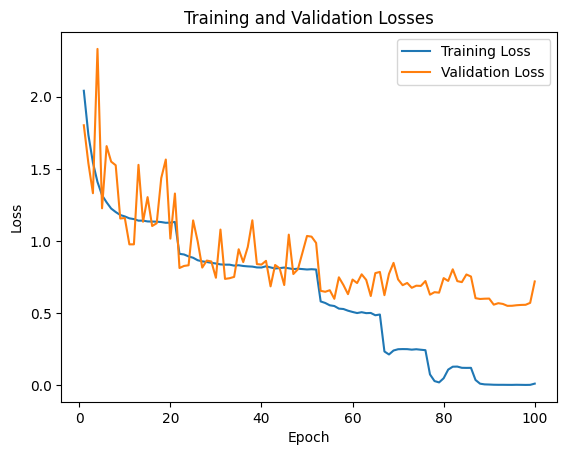

In [10]:
# Plotting the training and validation losses
import matplotlib.pyplot as plt

plt.plot(range(1, n_epochs+1), trainloss_list, label='Training Loss')
plt.plot(range(1, n_epochs+1), validloss_list, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()


In [11]:
# Model size 11173962
total_params = sum(p.numel() for p in model.parameters())
print("Total number of parameters: ", total_params)


Total number of parameters:  11173962
